# Clustering the protein dataset

The goal is to cluster the data with several different methods, in order to find the annotations that match the clusters thee best. 

In [1]:
import seaborn as sns
import pandas as pd

sns.set(rc={"figure.figsize": (15, 12)})
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from subpred.compositions import calculate_aac, calculate_paac
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from subpred.dataset import create_dataset, SUBSTRATE_KEYWORDS
from subpred.dataset import get_go_df, get_keywords_df, get_tcdb_substrates
from subpred.go_utils import GeneOntology


## Creating the datasets

### Protein datasets

In [2]:
import sys
import pandas as pd
sys.getsizeof(pd.Series(["A","B","C","A","B","C","A","B","C"]))
sys.getsizeof(pd.Series(["A","B","C","A","B","C","A","B","C"], dtype="category"))
sys.getsizeof(pd.Series([0,1,2,0,1,2,0,1,2]))
# sys.getsizeof(pd.Series([0,1,2,0,1,2,0,1,2], dtype="category"))

# sys.getsizeof([0,1,2])

216

In [3]:

df_uniprot = create_dataset(
    input_file="../data/raw/uniprot/uniprot_2022_05_evidence1-2_nofragments.tsv",
    # keywords_classes = None,
    # keywords_classes_all = SUBSTRATE_KEYWORDS,
    # keywords_filter = None,
    multi_substrate="keep",
    # outliers=outliers,
    verbose=True,
    # tax_ids_filter=[3702, 9606, 83333, 559292],
    # sequence_clustering=70,
    evidence_code=2,
    invalid_amino_acids="remove_amino_acids",
    # gene_names_only = True,
    # force_update=True,
    # remove_sequence_fragments = True,
    # force_update = False,
    tcdb_substrates_file="../data/raw/tcdb/tcdb_substrates.tsv",
    swissprot_only=False,
)
print(df_uniprot.shape)
df_uniprot.head()


Found pickle, reading...
(1021957, 16)


,gene_names,protein_names,reviewed,protein_existence,sequence,organism_id,go_ids,keyword_ids,keywords,tcdb_id,interpro,tcdb_class,tcdb_substrates,keywords_substrates,keywords_transport_related,keywords_location
Uniprot,,,,,,,,,,,,,,,,
A0A0C5B5G6,MT-RNR1,Mitochondrial-derived peptide MOTS-c (Mitochon...,reviewed,Evidence at protein level,MRWQEMGYIFYPRKLR,9606,GO:0001649; GO:0003677; GO:0005615; GO:0005634...,KW-0238; KW-0496; KW-0539; KW-0892; KW-1185; K...,DNA-binding;Mitochondrion;Nucleus;Osteogenesis...,NaN,NaN,0.0,NaN,,,
A0A1B0GTW7,CIROP LMLN2,Ciliated left-right organizer metallopeptidase...,reviewed,Evidence at protein level,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...,9606,GO:0004222; GO:0005737; GO:0006508; GO:0007155...,KW-0025; KW-0225; KW-0325; KW-1056; KW-0378; K...,Alternative splicing;Disease variant;Glycoprot...,NaN,IPR001577;,0.0,NaN,,,
A0JNW5,BLTP3B KIAA0701 SHIP164 UHRF1BP1L,Bridge-like lipid transfer protein family memb...,reviewed,Evidence at protein level,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,9606,GO:0005769; GO:0005829; GO:0034498; GO:0042803...,KW-0025; KW-0175; KW-0963; KW-0967; KW-0597; K...,Alternative splicing;Coiled coil;Cytoplasm;End...,NaN,IPR026728;IPR026854;,0.0,NaN,,,
A0JP26,POTEB3,POTE ankyrin domain family member B3,reviewed,Evidence at protein level,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...,9606,NaN,KW-0025; KW-0040; KW-0175; KW-1185; KW-0677,Alternative splicing;ANK repeat;Coiled coil;Re...,NaN,IPR002110;IPR036770;IPR039497;,0.0,NaN,,,
A0PK11,CLRN2,Clarin-2,reviewed,Evidence at protein level,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,9606,GO:0007605; GO:0032421; GO:0060088; GO:0060171...,KW-1003; KW-0966; KW-0209; KW-0225; KW-0325; K...,Cell membrane;Cell projection;Deafness;Disease...,9.A.46.1.2,IPR026748;,9.A,NaN,,,


In [4]:
# df_swissprot = df_uniprot[df_uniprot.reviewed == "reviewed"]
# df_swissprot.shape


### Annotation datasets

In [5]:

df_kw_uniprot = get_keywords_df(df_uniprot)
df_kw_uniprot.head()


,Uniprot,keyword
0,A0A0C5B5G6,DNA-binding
1,A0A0C5B5G6,Mitochondrion
2,A0A0C5B5G6,Nucleus
3,A0A0C5B5G6,Osteogenesis
4,A0A0C5B5G6,Reference proteome


In [6]:
df_kw_uniprot_long = df_kw_uniprot.assign(dataset="keyword").rename(
    columns={"keyword": "annotation"}
)[["Uniprot", "dataset", "annotation"]]
df_kw_uniprot_long.head()


,Uniprot,dataset,annotation
0,A0A0C5B5G6,keyword,DNA-binding
1,A0A0C5B5G6,keyword,Mitochondrion
2,A0A0C5B5G6,keyword,Nucleus
3,A0A0C5B5G6,keyword,Osteogenesis
4,A0A0C5B5G6,keyword,Reference proteome


In [7]:
go = GeneOntology("../data/raw/ontologies/go.owl")

In [8]:
df_go_uniprot = get_go_df(df_uniprot, go)
df_go_uniprot.head()


,Uniprot,go_id,go_term
0,A0A0C5B5G6,GO:0001649,osteoblast differentiation
1,A0A0C5B5G6,GO:0003677,DNA binding
2,A0A0C5B5G6,GO:0005615,extracellular space
3,A0A0C5B5G6,GO:0005634,nucleus
4,A0A0C5B5G6,GO:0005739,mitochondrion


In [9]:
df_go_uniprot_long = df_go_uniprot.melt(
    id_vars=["Uniprot"],
    value_vars=["go_id", "go_term"],
    var_name="dataset",
    value_name="annotation",
)
# df_go_uniprot_long = df_go_uniprot_long[df_go_uniprot_long.dataset == "go_term"]
df_go_uniprot_long.head()


,Uniprot,dataset,annotation
0,A0A0C5B5G6,go_id,GO:0001649
1,A0A0C5B5G6,go_id,GO:0003677
2,A0A0C5B5G6,go_id,GO:0005615
3,A0A0C5B5G6,go_id,GO:0005634
4,A0A0C5B5G6,go_id,GO:0005739


In [10]:
# TODO TCDB classes
df_tcdb_uniprot = get_tcdb_substrates(df_uniprot)
df_tcdb_uniprot = df_tcdb_uniprot.assign(
    tcdb_class=df_tcdb_uniprot.tcdb_id.apply(lambda x: x[:3])
)
df_tcdb_uniprot.head()


,Uniprot,tcdb_id,chebi_id,chebi_term,tcdb_class
0,A6NI61,1.N.2.1.1,CHEBI:25367,molecule,1.N
1,A6NKB5,9.A.80.1.1,CHEBI:24636,proton,9.A
2,O00168,1.A.27.1.8,CHEBI:22563,anion,1.A
3,O00337,2.A.41.2.3,CHEBI:9175,sodium(1+),2.A
4,O00337,2.A.41.2.3,CHEBI:9893,uridine,2.A


In [11]:
df_tcdb_uniprot_long = df_tcdb_uniprot.melt(
    id_vars=["Uniprot"],
    value_vars=["tcdb_id", "chebi_id", "chebi_term"],
    var_name="dataset",
    value_name="annotation",
)
df_tcdb_uniprot_long.head()


,Uniprot,dataset,annotation
0,A6NI61,tcdb_id,1.N.2.1.1
1,A6NKB5,tcdb_id,9.A.80.1.1
2,O00168,tcdb_id,1.A.27.1.8
3,O00337,tcdb_id,2.A.41.2.3
4,O00337,tcdb_id,2.A.41.2.3


In [12]:

df_uniprot_interpro = (
    df_uniprot.interpro.dropna().str.rstrip(";").str.split(";").explode().str.strip()
)
assert df_uniprot_interpro[~df_uniprot_interpro.str.match("IPR[0-9]{6}")].shape[0] == 0
df_uniprot_interpro = df_uniprot_interpro.reset_index(
    drop=False
)  # [df_uniprot_interpro.isnull()]
df_uniprot_interpro


,Uniprot,interpro
0,A0A1B0GTW7,IPR001577
1,A0JNW5,IPR026728
2,A0JNW5,IPR026854
3,A0JP26,IPR002110
4,A0JP26,IPR036770
...,...,...
4190605,X5MFI4,IPR029044
4190606,X5MI49,IPR008630
4190607,X5MI49,IPR029044
4190608,X5MPI5,IPR008630


In [13]:
df_uniprot_interpro_long = df_uniprot_interpro.assign(dataset="interpro").rename(
    columns={"interpro": "annotation"}
)[["Uniprot", "dataset", "annotation"]]
df_uniprot_interpro_long.head()


,Uniprot,dataset,annotation
0,A0A1B0GTW7,interpro,IPR001577
1,A0JNW5,interpro,IPR026728
2,A0JNW5,interpro,IPR026854
3,A0JP26,interpro,IPR002110
4,A0JP26,interpro,IPR036770


In [14]:
df_uniprot_organism_long = (
    df_uniprot.organism_id.reset_index(drop=False)
    .drop_duplicates()
    .assign(dataset="organism_id")
    .rename(columns={"organism_id": "annotation"})[["Uniprot", "dataset", "annotation"]]
)


### Dataframe containing all annotations

In [15]:
df_annotations = pd.concat(
    [
        df_kw_uniprot_long,
        df_go_uniprot_long,
        df_tcdb_uniprot_long,
        df_uniprot_interpro_long,
        df_uniprot_organism_long,
    ],
    ignore_index=True,
)

df_annotations = df_annotations[~df_annotations.duplicated()]

assert df_annotations[df_annotations.Uniprot.isnull()].shape[0] == 0
assert df_annotations[df_annotations.dataset.isnull()].shape[0] == 0
assert df_annotations[df_annotations.annotation.isnull()].shape[0] == 0

df_annotations.head()


,Uniprot,dataset,annotation
0,A0A0C5B5G6,keyword,DNA-binding
1,A0A0C5B5G6,keyword,Mitochondrion
2,A0A0C5B5G6,keyword,Nucleus
3,A0A0C5B5G6,keyword,Osteogenesis
4,A0A0C5B5G6,keyword,Reference proteome


## Feature datasets

#### Annotation sets to filter proteins

In [16]:
transmembrane_transporter_go_terms = go.get_descendants(
    go.get_identifier("transmembrane transporter activity")
)
transmembrane_transporters = set(
    df_annotations[
        (df_annotations.dataset == "go_id")
        & df_annotations.annotation.isin(transmembrane_transporter_go_terms)
    ].Uniprot.unique()
)
sequences_transmembrane_transporters = df_uniprot.sequence[
    df_uniprot.sequence.index.isin(transmembrane_transporters)
]

#### Feature generation

In [17]:
df_aac = calculate_aac(sequences_transmembrane_transporters)
df_paac = calculate_paac(sequences_transmembrane_transporters)
df_biovec = pd.read_table("/home/ad/biovec_test/uniprot_transporter_sequences_encoded.tsv", index_col=0)


## Functions

In [18]:
def elbow_plot(df, title:str, k_min=2, k_max=20, random_state=0):
    inertias = []
    k_values = list(range(k_min, k_max))
    for k in k_values:
        kmeans_tmp = KMeans(random_state=random_state, n_clusters=k)
        kmeans_tmp.fit(df)
        inertias.append(kmeans_tmp.inertia_)

    ax=pd.Series(data=inertias, index=k_values).plot()
    ax.set_title(title)
    ax.set_xlabel("k")
    ax.set_ylabel("inertia")
    plt.show()

In [19]:
def kmeans_pca_plot(df, title:str, num_clusters:int, random_state=0):
    pipe_cluster = make_pipeline(StandardScaler(), KMeans(n_clusters=num_clusters, random_state=random_state))

    pipe_cluster.fit(df)
    labels_kmeans = pipe_cluster["kmeans"].labels_

    pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=2,random_state=random_state))
    df_pca = pd.DataFrame(pipe_pca.fit_transform(df), columns=["PC1", "PC2"])
    ax = sns.scatterplot(df_pca, x="PC1", y="PC2", hue=labels_kmeans, palette="Set1", s=20)
    ax.set_title(title)

    plt.show()


In [20]:
def kmeans_tsne_plot(df, title:str, num_clusters:int, num_pcs:int=None, random_state=0):
    pipe_cluster = make_pipeline(StandardScaler(), KMeans(n_clusters=num_clusters, random_state=random_state))

    pipe_cluster.fit(df)
    labels_kmeans = pipe_cluster["kmeans"].labels_
    if num_pcs is None:
        pipe_tsne = make_pipeline(
            StandardScaler(),
            TSNE(n_components=2, learning_rate="auto", init="pca", random_state=random_state, n_jobs=-1),
        )
    else:
        pipe_tsne = make_pipeline(
            StandardScaler(),
            PCA(n_components=num_pcs, random_state=random_state),
            # StandardScaler(),
            TSNE(n_components=2, learning_rate="auto", init="pca", random_state=random_state, n_jobs=-1),
        )
    df_tsne = pd.DataFrame(pipe_tsne.fit_transform(df), columns=["x", "y"])
    ax = sns.scatterplot(df_tsne, x="x", y="y", hue=labels_kmeans, palette="Set1", s=20)
    ax.set_title(title)
    plt.show()

In [49]:
def annotation_tsne_plot(df, title:str, annotation_series:pd.Series, num_pcs:int=None, random_state=0):
    # pipe_cluster = make_pipeline(StandardScaler(), KMeans(n_clusters=num_clusters, random_state=random_state))
    # assert df.shape[0] == len(annotation_series)

    pipe_list = []
    pipe_list.append(StandardScaler())
    if num_pcs is not None:
        pipe_list.append(PCA(n_components=num_pcs, random_state=random_state))
    pipe_list.append(TSNE(n_components=2, learning_rate="auto", init="pca", random_state=random_state, n_jobs=-1))
    pipe_tsne = make_pipeline(*pipe_list)
    print(pipe_tsne)
    # pipe_cluster.fit(df)
    # labels_kmeans = pipe_cluster["kmeans"].labels_
    # if num_pcs is None:
    #     pipe_tsne = make_pipeline(
    #         StandardScaler(),
    #         TSNE(n_components=2, learning_rate="auto", init="pca", random_state=random_state, n_jobs=-1),
    #     )
    # else:
    #     pipe_tsne = make_pipeline(
    #         StandardScaler(),
    #         PCA(n_components=num_pcs, random_state=random_state),
    #         # StandardScaler(),
    #         TSNE(n_components=2, learning_rate="auto", init="pca", random_state=random_state, n_jobs=-1),
    #     )
    df_tsne = pd.DataFrame(pipe_tsne.fit_transform(df), columns=["x", "y"])
    ax = sns.scatterplot(df_tsne, x="x", y="y", hue=annotation_series, palette="Set1", s=20)
    ax.set_title(title)
    plt.show()

## Trying AAC/PAAC + sklearn

### AAC Plots

#### Elbow Plot

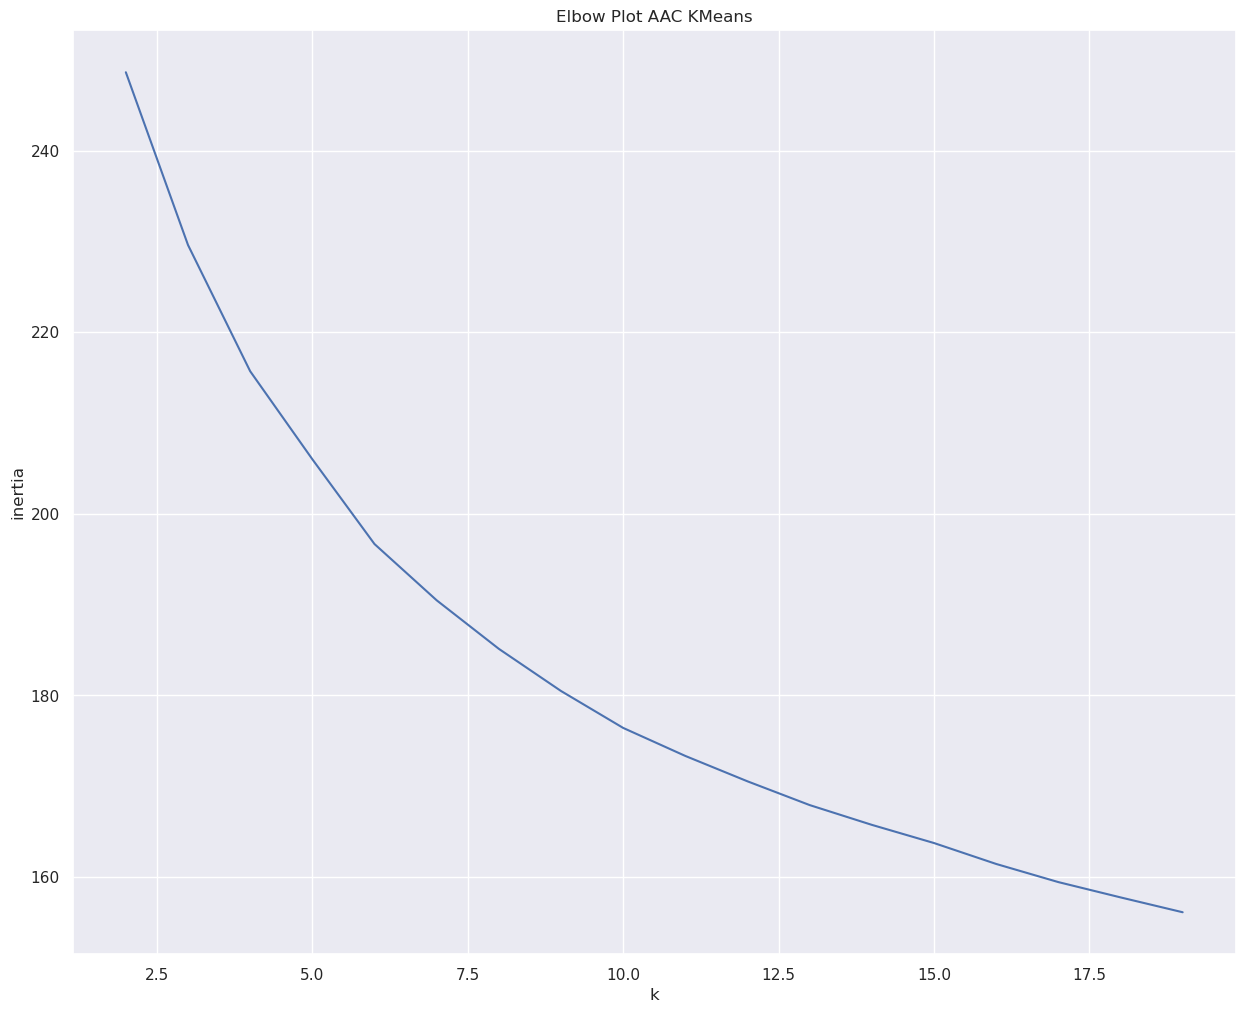

In [21]:
elbow_plot(df_aac, "Elbow Plot AAC KMeans")

#### Kmeans + PCA

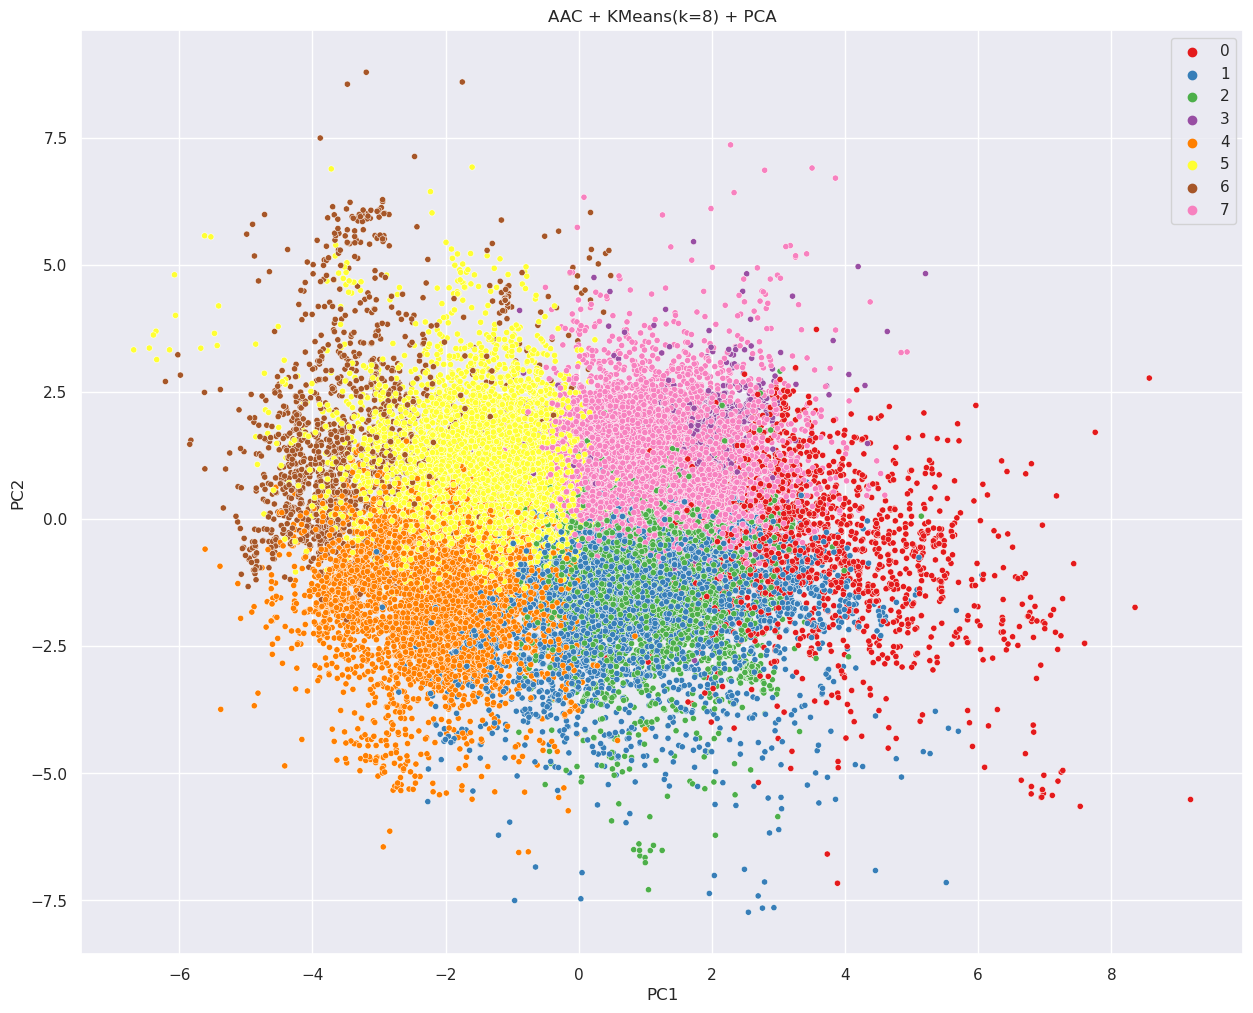

In [22]:
kmeans_pca_plot(df_aac, title="AAC + KMeans(k=8) + PCA", num_clusters=8)

#### Kmeans + TSNE

In [23]:
kmeans_tsne_plot(df_aac, "AAC + KMeans(k=8) + TSNE", num_clusters=8)

/home/ad/mambaforge/envs/subpred4/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# What are the dots? Investigating one of them!

# print(df_uniprot.loc[df_aac.index[df_pca[(df_pca.x > 62) & (df_pca.y > 98)].index]].protein_names.value_counts())

# print(df_uniprot.loc[df_aac.index[df_pca[(df_pca.PC1 > 62) & (df_pca.PC2 > 98)].index]].organism_id.value_counts())
# display(df_uniprot.loc[df_aac.index[df_pca[(df_pca.PC1 > 62) & (df_pca.PC2 > 98)].index]].head())

# All of them are lamB Maltoporin (Maltose-inducible porin) from different organisms!

### PAAC Plots

#### Elbow

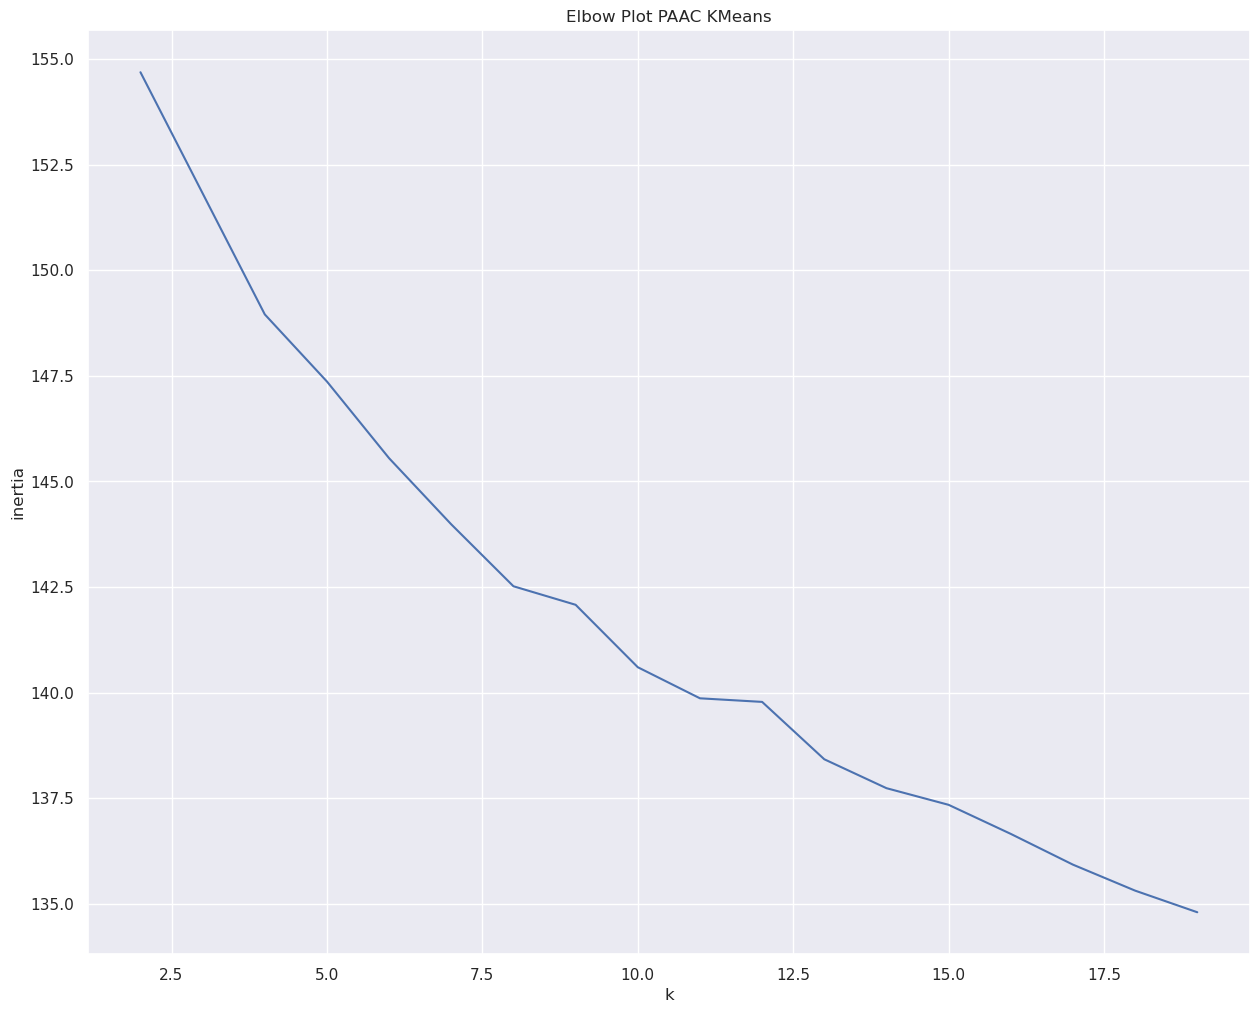

In [ ]:
elbow_plot(df_paac, "Elbow Plot PAAC KMeans")

#### Kmeans + PCA

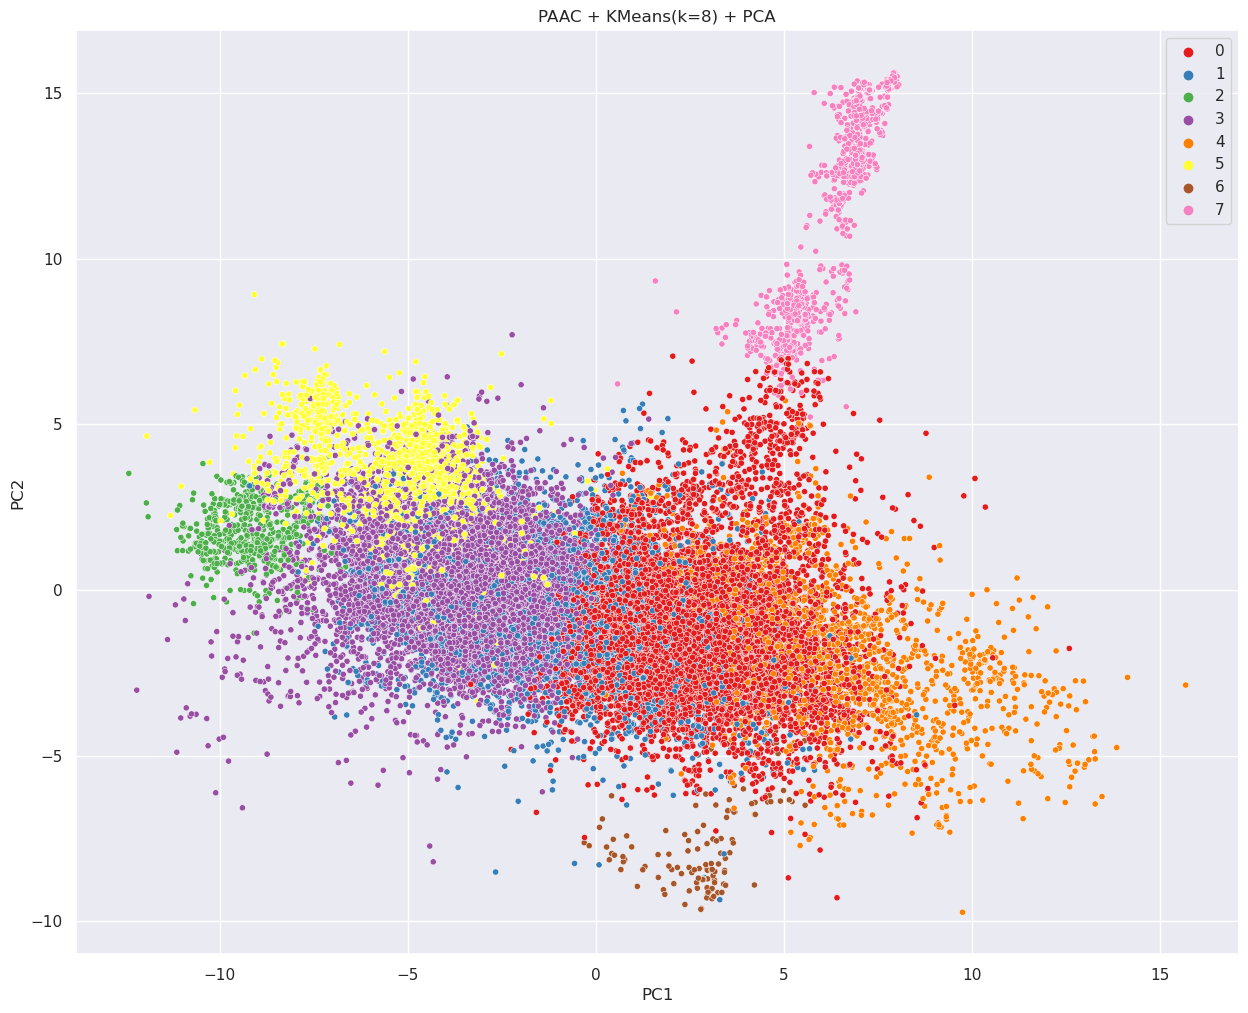

In [ ]:
kmeans_pca_plot(df_paac, "PAAC + KMeans(k=8) + PCA", num_clusters=8)

##### Kmeans + PCA + TSNE

performing pca...


/home/ad/mambaforge/envs/subpred4/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


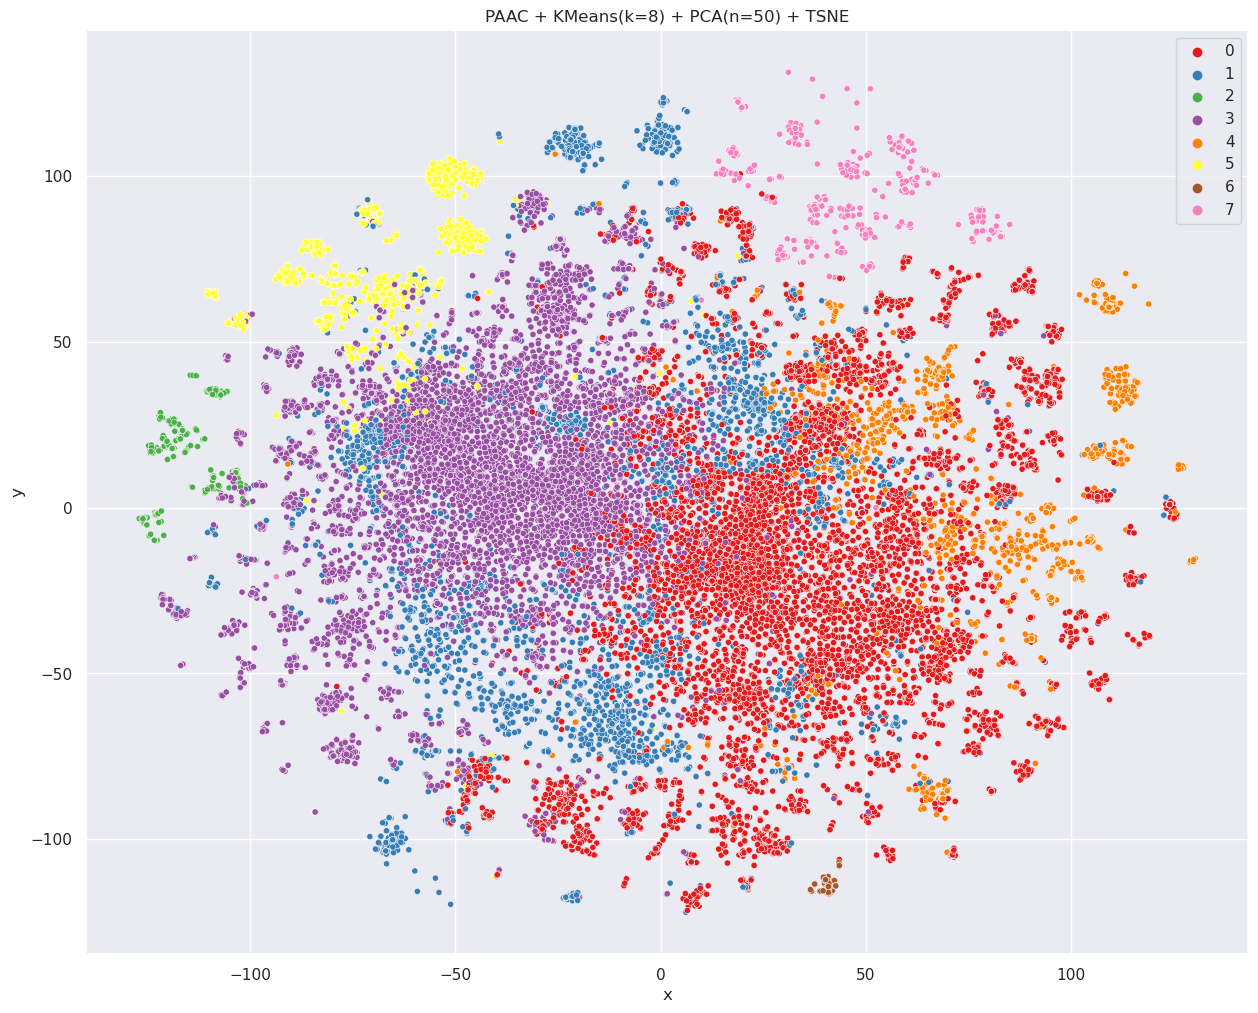

In [ ]:
kmeans_tsne_plot(df_paac, title="PAAC + KMeans(k=8) + PCA(n=50) + TSNE", num_clusters=8, num_pcs=50)

## Trying PSSM encoding

In [ ]:
# TODO

## Trying NLP encodings with Word2Vec

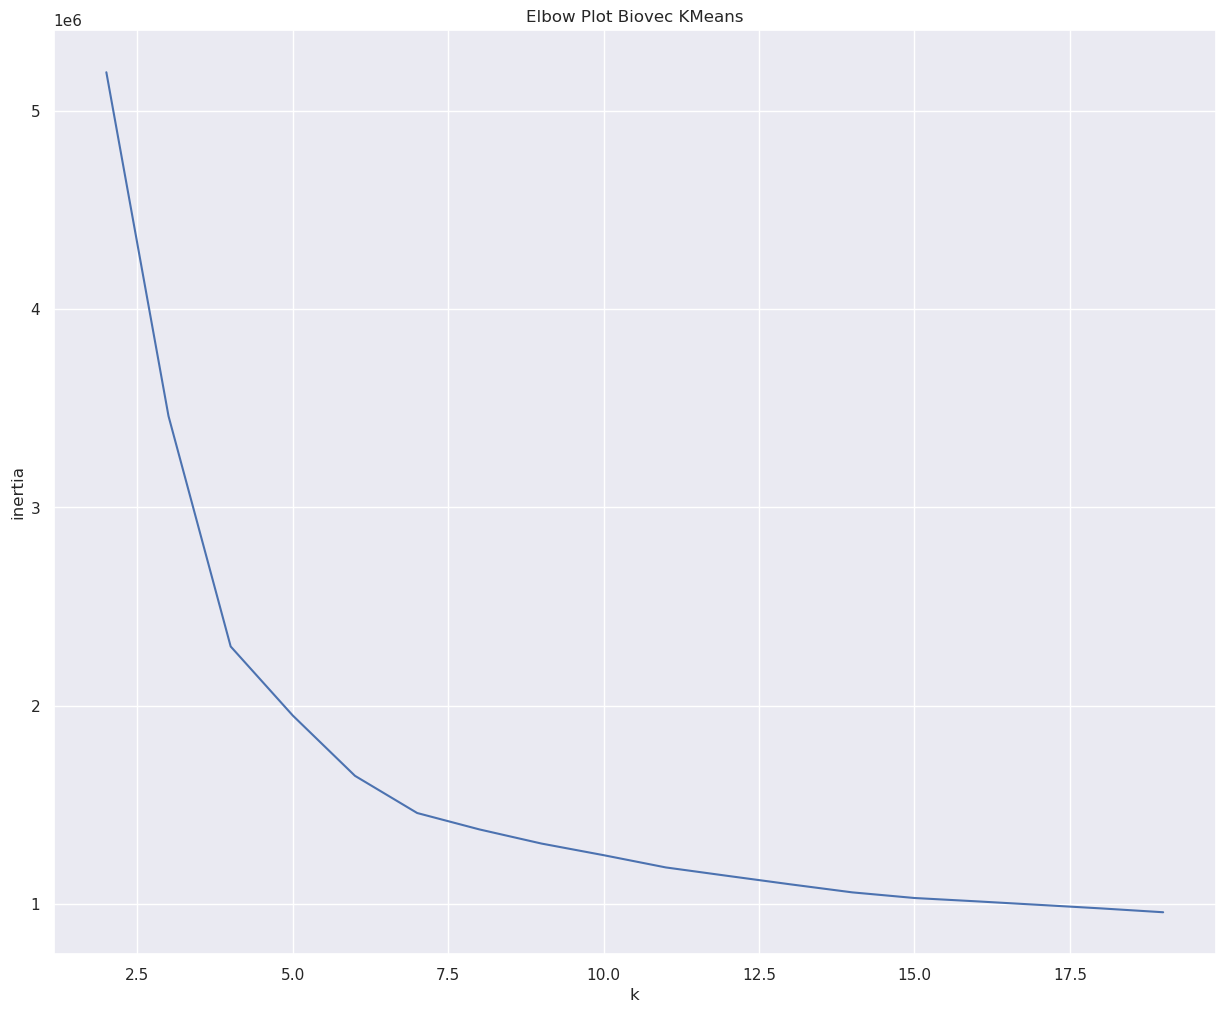

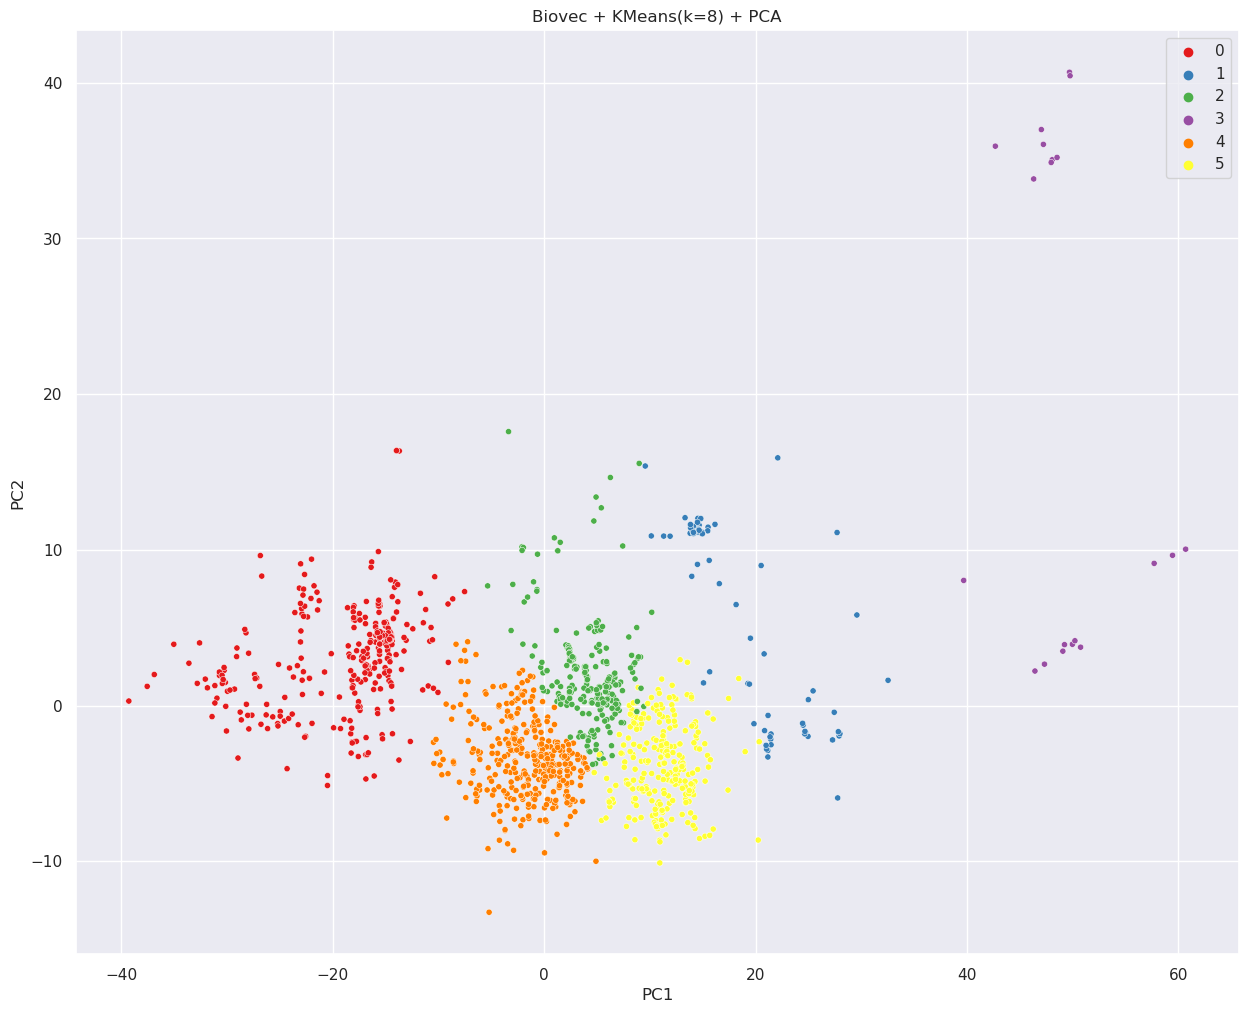

/home/ad/mambaforge/envs/subpred4/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


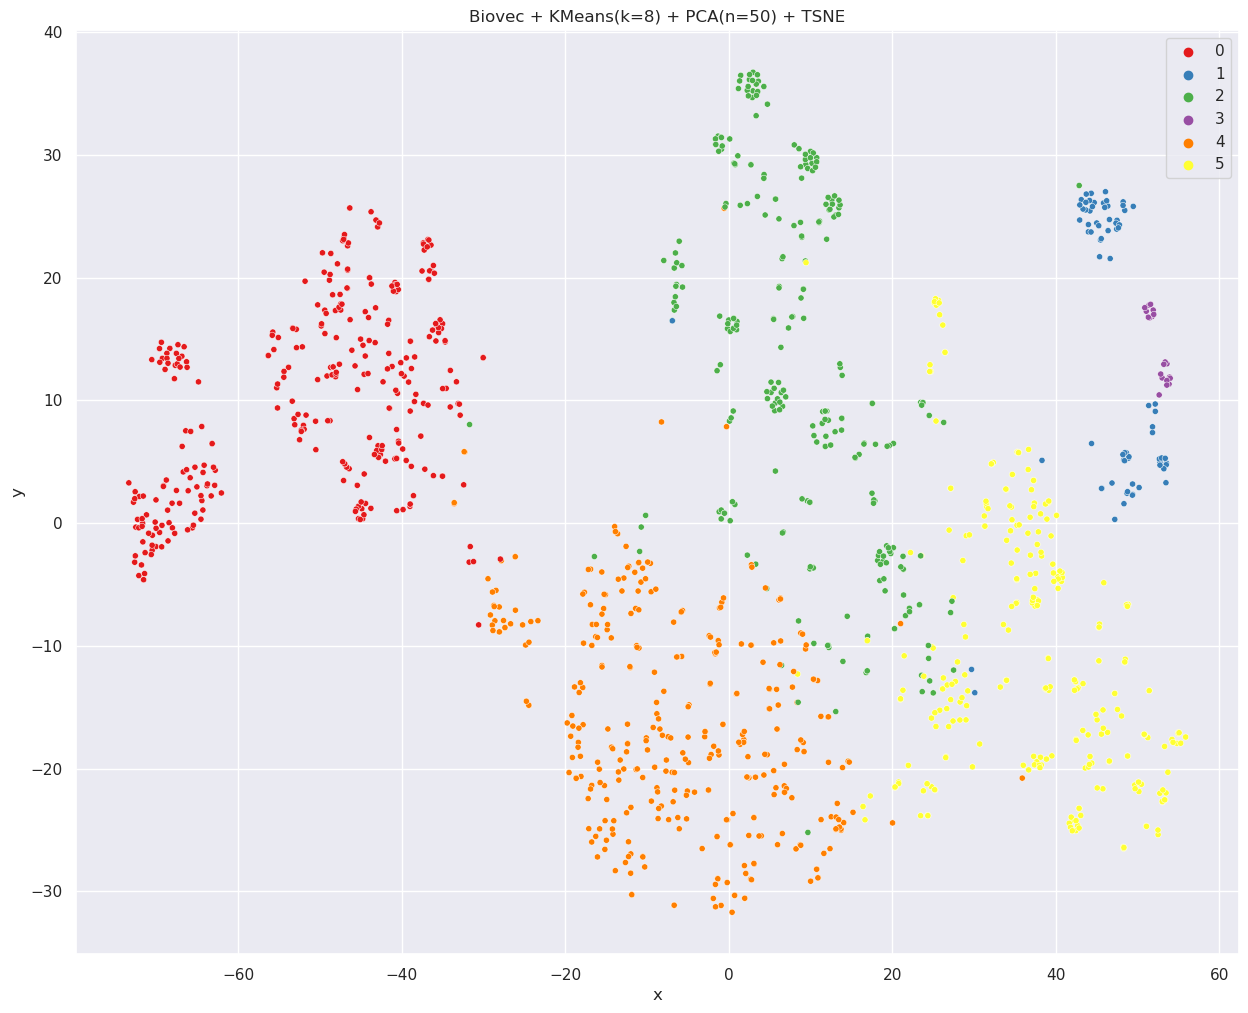

In [ ]:
elbow_plot(df_biovec, title="Elbow Plot Biovec KMeans")
kmeans_pca_plot(df_biovec, title="Biovec + KMeans(k=8) + PCA", num_clusters=6)
kmeans_tsne_plot(df_biovec,title="Biovec + KMeans(k=8) + PCA(n=50) + TSNE",num_clusters=6,num_pcs=50)

## Comparing clusters with annotations

In [ ]:
df_annotations_tcdb = df_annotations[df_annotations.dataset == "tcdb_id"]#.annotation.transform(lambda x: x[0])
df_annotations_tcdb = df_annotations_tcdb.assign(annotation = df_annotations_tcdb.annotation.transform(lambda x: x[0]))
df_annotations_tcdb = df_annotations_tcdb[["Uniprot", "annotation"]].drop_duplicates()
df_annotations_tcdb = df_annotations_tcdb.set_index("Uniprot", verify_integrity=True, drop=True)
# df_annotations_tcdb = df_annotations_tcdb[df_annotations_tcdb.index.isin(df_biovec.index)]

tcdb_class_dict = df_annotations_tcdb.annotation.to_dict()

# df_biovec_tcdb = df_biovec[df_biovec.index.isin(df_annotations_tcdb.index)]
tcdb_annotation = df_biovec.index.to_series().transform(lambda x: tcdb_class_dict[x] if x in tcdb_class_dict.keys() else 0)
annotation_tsne_plot(df_biovec,annotation_series=tcdb_annotation.tolist(),title="Annotation & Biovec + PCA(n=50) + TSNE",num_pcs=50)


## Trying Sequence clustering CLI programs:
- CD-Hit
- MMseq2
    - Most important parameters: https://github.com/soedinglab/MMseqs2/wiki#clustering-criteria
    - Output format: Long TSV TODO write parser
    - Disadvantage: No pairwise scores, no PCA plots

In [30]:
# Fasta export TODO temp file
from subpred.fasta import write_fasta

fasta_file_name = "/home/ad/tmp.fasta"

# df_uniprot_test = df_uniprot[
#     (df_uniprot.reviewed == "reviewed")
#     & (df_uniprot.protein_existence == "Evidence at protein level")
# ]
df_uniprot_test = df_uniprot[
    (df_uniprot.protein_existence == "Evidence at protein level")
]
df_uniprot_test = df_uniprot_test.sequence.reset_index(drop=False)
df_uniprot_test = df_uniprot_test[~df_uniprot_test.duplicated()]
sequences_test = df_uniprot_test.set_index("Uniprot", drop=True).sequence
# write_fasta(fasta_file_name, fasta_data)


In [31]:
transmembrane_transporter_terms = go.get_descendants(
    go.get_identifier("transmembrane transporter activity")
)
transmembrane_transporters = set(
    df_annotations[
        (df_annotations.dataset == "go_id")
        & df_annotations.annotation.isin(transmembrane_transporter_terms)
    ].Uniprot.unique()
)

sequences_uniprot = df_uniprot.sequence
sequences_transmembrane_transporters = sequences_uniprot[
    sequences_uniprot.index.isin(transmembrane_transporters)
]
# df_uniprot[
#     (df_uniprot.protein_existence == "Evidence at protein level")
# ]


In [32]:
amino_transporter_terms = go.get_descendants(
    go.get_identifier("amino acid transmembrane transporter activity")
)
amino_transporters = set(
    df_annotations[
        (df_annotations.dataset == "go_id")
        & df_annotations.annotation.isin(amino_transporter_terms)
    ].Uniprot.unique()
)

sequences_uniprot = df_uniprot.sequence
sequences_amino_transporters = sequences_uniprot[
    sequences_uniprot.index.isin(amino_transporters)
]

### using cd-hit

- wrote parser for results file

cd-hit: clustered .......... sequences into finished clusters at threshold 40


Text(0.5, 1.0, 'CD-HIT clusters of transmembrane transporter sequences')

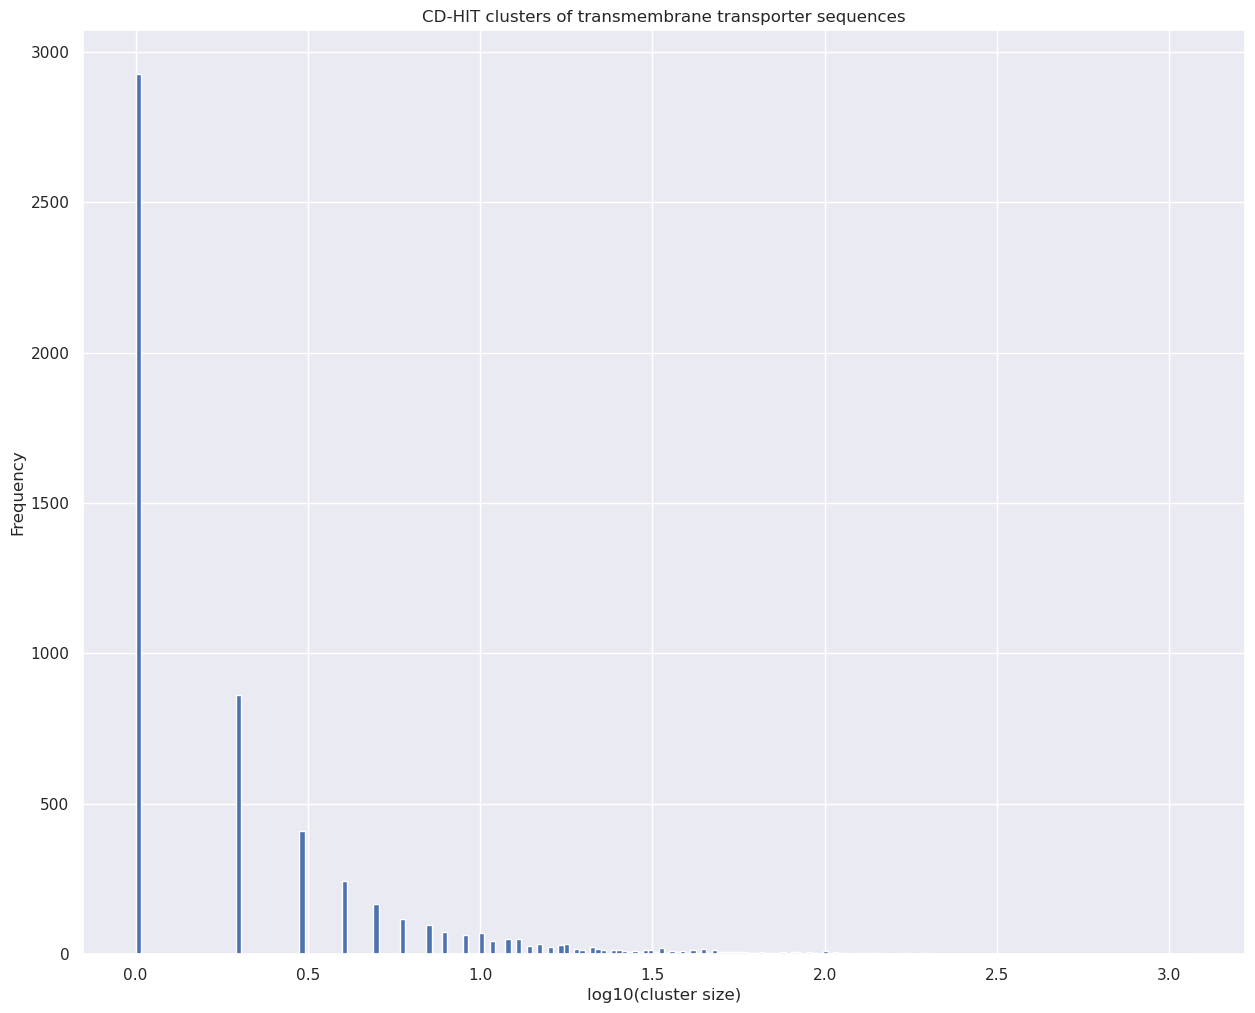

In [33]:
from subpred.cdhit import cd_hit
import numpy as np

cdhit_res = cd_hit(
    sequences_transmembrane_transporters,
    identity_threshold=40,
    n_threads=80,
    return_cluster_file=True,
)
ax = cdhit_res.groupby("cluster").apply(len).apply(np.log10).plot.hist(bins=200)
ax.set_xlabel("log10(cluster size)")
ax.set_title("CD-HIT clusters of transmembrane transporter sequences")

cd-hit: clustered 1347 sequences into 238 clusters at threshold 40


Text(0.5, 1.0, 'CD-HIT clusters of transmembrane transporter sequences threshold 40%')

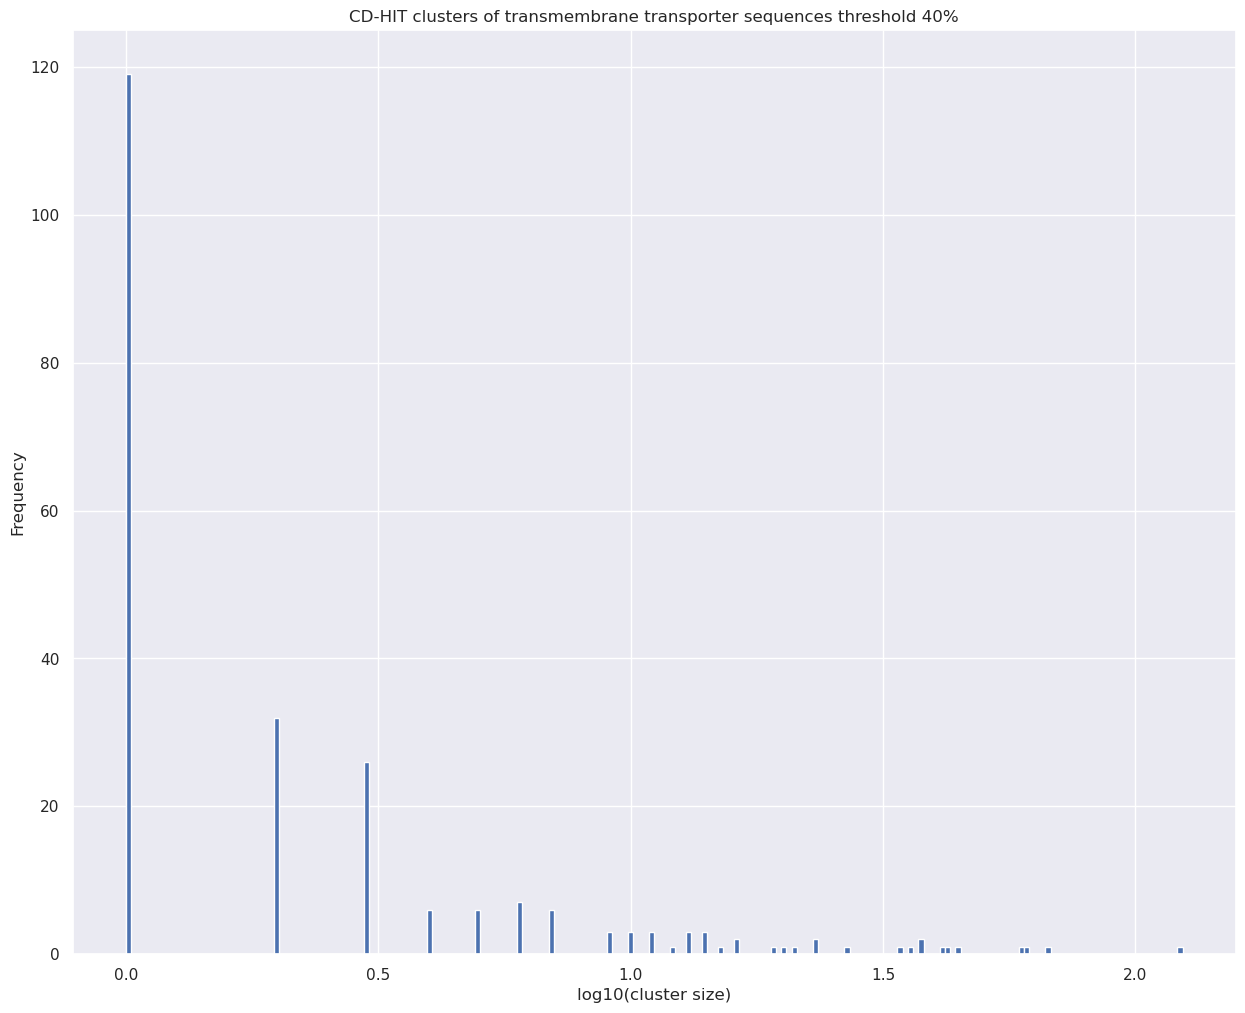

In [106]:
from subpred.cdhit import cd_hit
import numpy as np

cdhit_res = cd_hit(
    sequences_amino_transporters,
    identity_threshold=40,
    n_threads=80,
    return_cluster_file=True,
)
ax = cdhit_res.groupby("cluster").apply(len).apply(np.log10).plot.hist(bins=200)
ax.set_xlabel("log10(cluster size)")
ax.set_title("CD-HIT clusters of transmembrane transporter sequences threshold 40%")

Exporting sequences to generate NLP codes

In [35]:
sequences_transmembrane_transporters.to_csv("/home/ad/biovec_test/uniprot_transporter_sequences.tsv", sep="\t")

### Using mmseqs2

mmseqs easy-cluster tmp.fasta tmp_out.fasta tmp


--min-seq-id 0.5 -c 0.8 --cov-mode 1


 mmseqs easy-cluster examples/DB.fasta result tmp



In [37]:
import tempfile
import subprocess
import os
from subpred.fasta import read_fasta, write_fasta
import pandas as pd


def __flatten_kwargs(**kwargs):
    kwargs_list = list()
    for k, v in kwargs.items():
        kwargs_list.append(k)
        kwargs_list.append(v)
    return kwargs_list

def mmseq(
    sequences: pd.Series,
    fast_algo: bool = False,
    cluster_mode: int = 0,
    min_seq_id: float = 0.0,
    min_coverage: float = 0.8,
    cov_mode: int = 0,
    max_evalue: float = 1e-3,
    verbose: bool = False,
    **kwargs,

) -> pd.DataFrame:
    """Python wrapper for MMSeqs2

    Args:
        sequences (pd.Series):
            Series with identifiers as index and amino acid sequences as values
        fast_algo (bool, optional):
            Use linclust algorithm (for huge datasets). Defaults to False.
        cluster_mode (int, optional):
            0: Set-Cover (greedy)
            1: Connected component (BLASTclust)
            2,3: Greedy clustering by sequence length (CDHIT).
            Defaults to 0.
        min_seq_id (float, optional):
            List matches above this sequence identity (for clustering) (range 0.0-1.0). Defaults to 0.0.
        min_coverage (float, optional):
            -c. List matches above this fraction of aligned (covered) residues (see cov-mode). Defaults to 0.8.
        cov_mode (int, optional):
            0: coverage of query and target
            1: coverage of target
            2: coverage of query
            3-5 also exist
            Defaults to 0.
        max_evalue (float, optional):
            List matches below this E-value (range 0.0-inf). Defaults to 1e-3.
        verbose (bool, optional):
            Print command, and output of MMSeq2. Defaults to False.
    """

    with (
        tempfile.NamedTemporaryFile(suffix=".fasta") as tmp_fasta_in,
        tempfile.NamedTemporaryFile() as tmp_out,
        tempfile.TemporaryDirectory() as tmp_folder,
    ):
        fasta_data = list(
            zip(
                [">" + ac for ac in sequences.index.tolist()], sequences.values.tolist()
            )
        )
        write_fasta(fasta_file_name=tmp_fasta_in.name, fasta_data=fasta_data)

        seq_db_path = tmp_fasta_in.name.replace(".fasta", ".seqdb")

        cluster_fasta = tmp_out.name + "_all_seqs.fasta"
        cluster_tsv = tmp_out.name + "_cluster.tsv"
        cluster_representatives_fasta = tmp_out.name + "_rep_seq.fasta"

        execution = [
            "mmseqs",
            "easy-linclust" if fast_algo else "easy-cluster",
            # "easy-linclust",
            tmp_fasta_in.name,
            tmp_out.name,
            tmp_folder,
            "--cluster-mode",
            cluster_mode,
            "--min-seq-id",
            min_seq_id,
            "-c",
            min_coverage,
            "--cov-mode",
            cov_mode,
            "-e",
            max_evalue
        ] + __flatten_kwargs(**kwargs)
        execution = [
            str(argument) if not isinstance(argument, str) else argument
            for argument in execution
        ]
        result = subprocess.run(
            execution, check=True, stdout=subprocess.PIPE, universal_newlines=True
        )

        if verbose:
            print("==COMMAND==")
            print(" ".join(execution))
            print("==STDOUT==")
            print(result.stdout)
            print("==STDERR==")
            print(result.stderr)

        cluster_tsv = pd.read_table(cluster_tsv, header=None, names=["Rep", "Cluster"])

    return cluster_tsv


In [38]:
cluster_tsv = mmseq(
    sequences_transmembrane_transporters.drop_duplicates(),
    fast_algo=True,
    # cluster_mode=2,
    # min_seq_id=0,
    min_coverage=0.1,
    cov_mode=1,
    # max_evalue=1e-2,
)


In [39]:
cluster_tsv.duplicated().any()


False

466
1      3658
2      1263
3       612
4       338
5       215
       ... 
332       1
369       1
438       1
439       1
466       1
Length: 129, dtype: int64


Text(0.5, 0, 'log10(cluster size)')

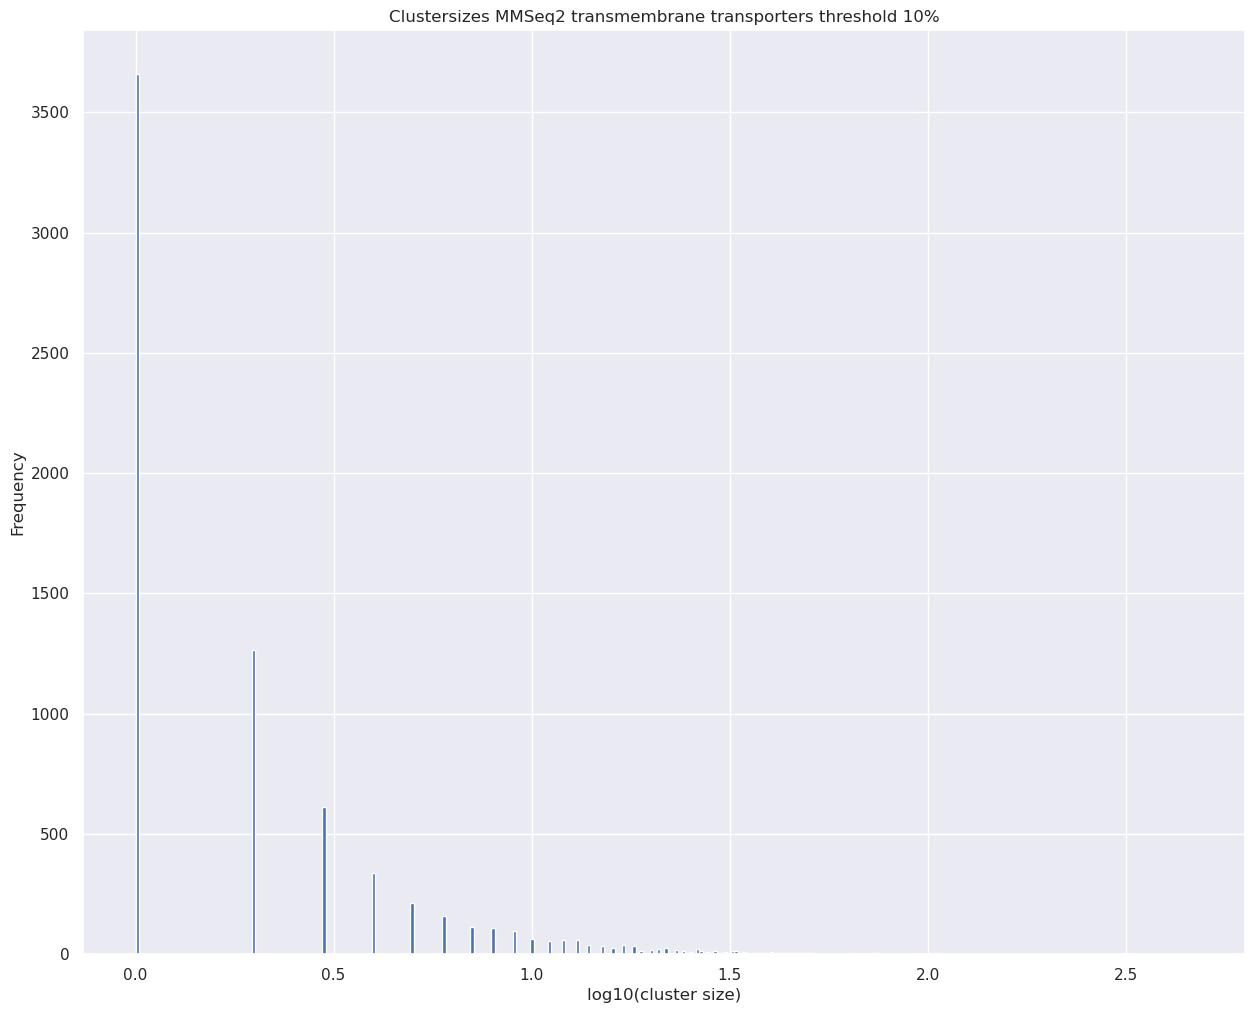

In [108]:
from math import log

print(cluster_tsv.drop_duplicates().groupby("Rep").apply(len).max())

print(
    cluster_tsv.drop_duplicates().groupby("Rep").apply(len).value_counts().sort_index()
)
ax = cluster_tsv.drop_duplicates().groupby("Rep").apply(len).apply(np.log10).plot.hist(bins=300)
ax.set_title("Clustersizes MMSeq2 transmembrane transporters threshold 10%")
ax.set_xlabel("log10(cluster size)")